Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Loading data...
apple_1_1_100_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_100_maskcrop.png
apple_1_1_101_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_101_maskcrop.png
apple_1_1_102_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_102_maskcrop.png
apple_1_1_103_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_103_maskcrop.png
apple_1_1_104_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_104_maskcrop.png
apple_1_1_105_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_105_maskcrop.png
apple_1_1_106_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_106_maskcrop.png
apple_1_1_107_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_107_maskcrop.png
apple_1_1_108_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_108_maskcrop.png
apple_1_1_109_depthcrop.png
dataset/rgbd-dataset\apple\apple_1\apple_1_1_109_maskcrop.png
apple_1_1_10_depth

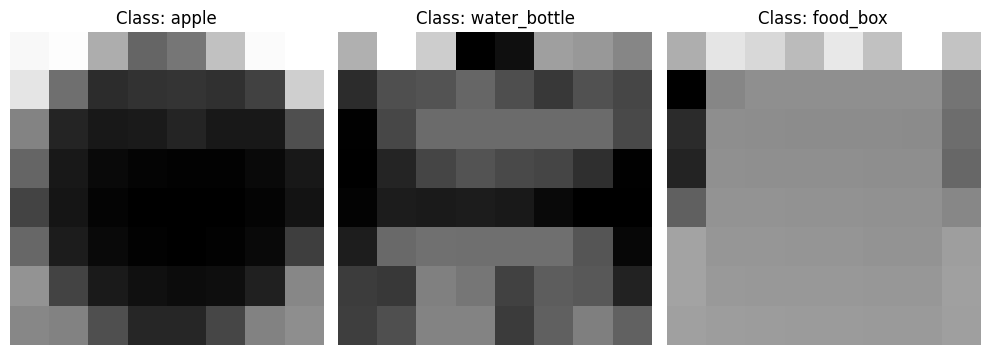

In [1]:
%pip install opencv-python
%pip install scikit-learn
%pip install tensorflow
%pip install matplotlib
import tensorflow as tf
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters
CLASSES = ["apple", "calculator", "water_bottle", "food_box"]  # 4 classes from paper
IMG_SIZE = (8, 8)  # Target ultra-low resolution
DATA_PATH = "dataset/rgbd-dataset"  # Base path to your dataset


def get_bbox_from_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    return x,y,w,h


def load_depth_maps(class_names, data_path):
    images, labels = [], []
    
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        
        for instance_folder in sorted(os.listdir(class_path)):
            instance_path = os.path.join(class_path, instance_folder)
            if not os.path.isdir(instance_path):
                continue

            # Process each _depth.png and match with its _mask.png
            for file in sorted(os.listdir(instance_path)):
                if file.endswith("_depthcrop.png"):
                    base_prefix = file.replace("_depthcrop.png", "")
                    depth_path = os.path.join(instance_path, file)
                    mask_path = os.path.join(instance_path, f"{base_prefix}_maskcrop.png")

                    # Check if both files exist
                    if not os.path.isfile(depth_path) or not os.path.isfile(mask_path):
                        print(f"Missing pair for {file}")
                        continue

                    # Get bounding box from corresponding mask
                    bbox = get_bbox_from_mask(mask_path)
                    print(file)
                    print(mask_path)
                    if not bbox:
                        print(f"Invalid or empty mask for {mask_path}")
                        continue
                    x, y, w, h = bbox

                    # Load and crop depth image
                    depth_img = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
                    if depth_img is None or depth_img.shape == ():
                        print(f"Invalid depth image at {depth_path}")
                        continue

                    height, width = depth_img.shape
                    x1, y1 = max(0, x), max(0, y)
                    x2, y2 = min(width, x + w), min(height, y + h)

                    if x2 <= x1 or y2 <= y1:
                        print(f"Invalid bbox in {depth_path}")
                        continue

                    cropped = depth_img[y1:y2, x1:x2]
                    resized = cv2.resize(cropped, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    normalized = resized.astype('float32') / 4000.0  # Adjust if needed

                    images.append(normalized)
                    labels.append(label)
    
    return np.array(images), np.array(labels)

    
    

# Load the data
print("Loading data...")
X, y = load_depth_maps(CLASSES, DATA_PATH)
X = X.reshape(-1, 8, 8, 1)  # Reshape for CNN input

# Split data (70% train, 15% val, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

print("\nData loaded successfully!")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Visualize sample
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Class: {CLASSES[np.argmax(y_train[i])]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [2]:
print("Label counts:", np.unique(y, return_counts=True))

Label counts: (array([0, 1, 2, 3]), array([3098, 2934, 5691, 4787]))


In [3]:
import tensorflow as tf

model = tf.keras.Sequential([
    # Input: 8x8x1 (normalized depth maps)
    tf.keras.layers.Conv2D(
        filters=3,                  # 3 kernels (paper: "3 channels")
        kernel_size=(3, 3),         # 3x3 convolutions
        activation='relu',
        padding='same',             # Preserves spatial dimensions (8x8)
        input_shape=(8, 8, 1)       # Input shape
    ),
    tf.keras.layers.Dropout(0.25),  # 25% dropout (paper: after each conv layer)
    
    # Second conv layer
    tf.keras.layers.Conv2D(
        filters=4,                  # 4 kernels (paper: "4 channels")
        kernel_size=(3, 3),
        activation='relu',
        padding='valid'             # No padding → output shrinks to 6x6
    ),
    tf.keras.layers.Dropout(0.25),
    
    # Classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=4,                    # 4 classes (apple, calculator, water_bottle, food_box)
        activation='softmax'
    )
])

c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
### Test
#def step_decay(epoch):
   # initial_lr = 0.01
  #  drop_factor = 0.5
  #  epochs_drop = 15
 #   return initial_lr * (drop_factor ** (epoch // epochs_drop))

#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)
### 


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import gc
y_train_classes = np.argmax(y_train, axis=1)
#model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),  # SGD (not Adam!) for stability
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
initial_weights=model.get_weights()
# Compute class weights
best_acc=0
best_weights = [0,0,0,0]
i=0
k=0
l=0
while i<4:
    j=0
    k=0
    l=0
    while j<4:
        k=0
        l=0
        while k<4:
            l=0
            while l<4:
                tf.keras.backend.clear_session()
                gc.collect()
                model.compile(
                    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),  # SGD (not Adam!) for stability
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                model.set_weights(initial_weights)
                class_weights = {0:4+1*i,
                                1:4+1*j,
                                2:4+1*k,
                                3:4+1*l}
                print("Peso apple:",class_weights[0])
                print("Peso calc:", class_weights[1])
                print("Peso water bottle:",class_weights[2])
                print("Peso food box:", class_weights[3])
                # Convert to dictionary format expected by Keras
                #class_weights = dict(enumerate(class_weights))

                history = model.fit(
                    X_train, y_train,
                    epochs=50,                     # Paper used 300 epochs
                    batch_size=32,                  # Paper: 32 for 4 classes
                    validation_data=(X_val, y_val),
                    class_weight=class_weights,     # Your computed weights
                    callbacks=[
                        tf.keras.callbacks.LearningRateScheduler(
                            lambda epoch, lr: lr * 0.5 if (epoch + 1) % 15 == 0 else lr  # LR decay every 15 epochs
                        ),
                        tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        patience=6,
                        restore_best_weights=True
                        )
                    ]
                )
                last_train_acc = history.history['accuracy'][-1]
                if best_acc<=last_train_acc:
                    best_acc = last_train_acc
                    best_weights = class_weights
                    
                print("#######################")
                print("\n")
                print("Mejor Accuracy:", best_acc)    
                print("Mejor Peso apple:",best_weights[0])
                print("Mejor Peso calc:", best_weights[1])
                print("Mejor Peso water bottle:",best_weights[2])
                print("Mejor Peso food box:", best_weights[3])    
                print("\n")
                print("#######################")

                l+=1
            k+=1    
        j+=1
    i+=1




Peso apple: 4
Peso calc: 4
Peso water bottle: 4
Peso food box: 4
Epoch 1/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3276 - loss: 5.4819 - val_accuracy: 0.3538 - val_loss: 1.3291 - learning_rate: 0.0010
Epoch 2/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3577 - loss: 5.3037 - val_accuracy: 0.3538 - val_loss: 1.2752 - learning_rate: 0.0010
Epoch 3/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3584 - loss: 5.0690 - val_accuracy: 0.3930 - val_loss: 1.1626 - learning_rate: 0.0010
Epoch 4/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4490 - loss: 4.6392 - val_accuracy: 0.5945 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 5/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5859 - loss: 4.0018 - val_accuracy: 0.5985 - val_loss: 0.8595 - learning_rate: 0.0010
Epoch 6/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6191 - loss: 3.5597 - val_accuracy: 0.6785 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 7/50
362/362 ━━━

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


In [ ]:
from sklearn.metrics import confusion_matrix
%pip install seaborn
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Check class distribution in true labels
print("True class counts:", np.bincount(y_true_classes))

# Check class distribution in predictions
print("Predicted class counts:", np.bincount(y_pred_classes))

# Check raw confusion matrix (counts)
print("Raw CM (counts):\n", confusion_matrix(y_true_classes, y_pred_classes))





class_names=["apple","calculator","food box","water bottle"]
# Compute confusion matrix (raw counts)
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Convert to percentages (row-wise: % of predictions per true class)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
plt.figure(figsize=(8, 6))
plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.colorbar(format='%.2f%%')

# Add labels
class_names = ['apple', 'calculator', 'water_bottle', 'food_box']  # Replace with your class names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Annotate cells with percentages
thresh = cm_percent.max() / 2.
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        plt.text(j, i, f'{cm_percent[i, j]:.1f}%',
                 horizontalalignment="center",
                 color="white" if cm_percent[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (%)')
plt.tight_layout()
plt.show()

In [ ]:
unique, counts = np.unique(y_true_classes, return_counts=True)
print("Class distribution:", dict(zip(class_names, counts)))

In [ ]:
preds = model.predict(X_test)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Asegúrate de tener la lista CLASSES definida
CLASSES = ["apple", "calculator", "water_bottle", "food_box"]

for i in range(len(X_test)):
    pred_class = np.argmax(preds[i])
    true_class = np.argmax(y_test[i])
    
    if pred_class == true_class:
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title(f"True: {CLASSES[true_class]}, Pred: {CLASSES[pred_class]}")
        plt.axis('off')
        plt.show()